In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
import csv
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale as scale_
from sklearn.dummy import DummyRegressor as MeanOnly
from matplotlib.pyplot import scatter  
import matplotlib.pyplot as plt
import gensim
import re

np.random.seed(2019)

C:\Users\Austin\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Austin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#A helper function that turns GloVe files into a dictionary

def get_glove(filename):
    with open(filename, 'r', encoding='utf8') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONE)
        return {line[0]: np.array(list(map(float, line[1: ])), dtype=float) for line in reader}

In [3]:
#Uploading the 300-dimension GloVe trained on the Common Crawl Corpus

glove1 = get_glove('glove.840B.300d.txt')

In [4]:
#Uploading the 200-dimension GloVe trained on Twitter data

glove2 = get_glove("glove.twitter.27B.200d.txt")

In [5]:
#Uploading the 300-dimension GloVe trained on Wikipedia data

glove3 = get_glove("glove.6B.300d.txt")

In [6]:
#Using the gensim library to upload the Word2Vec dictionary trained on Google News

word2vec = model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', 
                                                                   binary=True)

In [7]:
#List of holding onto data
data = []

with open('EPA_dict.csv', 'r') as f:
    
    #Pass over the first line of the file
    f.readline() 
    
    for line in f:

        line = line.lower().split(',')
        
        term = str(line[0])
        
        #Parse out the term, mark if beh, mod, or id
        
        beh_regex = ['^to\s([^\s]*)\s?(?:with|to|at|towards)?\ssomeone\sis$']
        id_regex = ['^an?\s([^\s]*)\sis$', '^(god) is$']
        mod_regex = ['^being\s([^\s]*)\sis$','^feeling\s([^\s]*)\sis$']
        
        beh = 0
        mod = 0
        id_ = 0
        
        for r in beh_regex:
            match = re.search(r, str(term))
            if match:
                term = match.group(1)
                beh = 1
                
        if not beh:
            for r in id_regex:
                match = re.search(r, str(term))
                if match:
                    term = match.group(1)
                    id_ = 1
       
        if not beh and not id_:
            for r in mod_regex:
                match = re.search(r, str(term))
                if match:
                    term = match.group(1)
                    mod = 1
                    
        if not any((beh, id_, mod)):
            #print("'{0}'".format(term),"NOT INCLUDED (REGEX)")
            pass
        
        #Only include terms that are present in each of the feature dictionaries
        elif term in glove1 and term in glove2 and term in glove3 and term in word2vec:
            E = float(line[2])
            P = float(line[3])
            A = float(line[4])

            data.append([term, E, P, A, beh, id_, mod])
            
        else:
            #print("'{0}'".format(term),"NOT INCLUDED (WORD EMBEDDINGS)")
            pass
        
columns = ['term', 'E', 'P', 'A', 'behavior', 'identity', 'modifier']

df = pd.DataFrame(data = data, columns=columns)

In [8]:
#Split the data into train and test splits
rand = np.random.rand(len(df)) < 0.8
train = df[rand]
test = df[~rand]

In [9]:
def testr(classifier_E, classifier_P, classifier_A, trainX, testX,
         trainE = train['E'], trainP = train['P'], trainA = train['A'], 
         testE=test['E'],testP=test['P'],testA=test['A'], norm=False, scale=False):
    
    '''
    A function which tests the performance of classifiers with given feature vectors.
    
    INPUT:
    
    classifier_E: an SK Lean classifier object to predict E ratings
    classifier_P: an SK Lean classifier object to predict P ratings
    classifier_A: an SK Lean classifier object to predict A ratings
    
    trainX: An n*k np array, where n is the number of observations in the training set and k is the number of features
    testX: An n*k np array, where n is the number of observations in the test set and k is the number of features

    trainE: An np-array of the E ratings of the training set
    trainP: An np-array of the P ratings of the training set
    trainA: An np-array of the A ratings of the training set
    
    testE: An np-array of the E ratings of the test set
    testP: An np-array of the P ratings of the test set
    testA: An np-array of the A ratings of the test set
    
    norm: a boolean value representing whether or not the features should be L2-normed
    scale: a boolean value representing whether or not the features should be mean-centered and scaled by variation (z-scored)
    
    OUTPUT:
    
    prints a report of the performance of the given classifiers with the given feature vectors
    
    returns a 6-element tuple containing the following elements in order:
    
    predicts_E: a np array of predicted E values for the test set
    predicts_P: a np array of predicted P values for the test set
    predicts_A: a np array of predicted A values for the test set

    classifier_E: the E-rating classifier fit to the training data
    classifier_P: the P-rating classifier fit to the training data
    classifier_A: the A-rating classifier fit to the training data
    '''

    if norm:
        trainX = normalize(trainX)
        testX = normalize(testX)

    if scale:
        trainX = scale_(trainX)
        testX = scale_(testX)


    classifier_E.fit(trainX, trainE)
    predicts_E = classifier_E.predict(testX)

    print('E R-sq: ',r2(testE, predicts_E))
    print('E MAE: ', mae(testE, predicts_E), "\n")
    
    e1 = classifier_E.predict(trainX)
    e1 = e1.reshape((len(e1),1))
    trainX = np.append(trainX,e1,1)
    
    e2 = predicts_E.reshape((len(predicts_E),1))
    testX = np.append(testX,e2,1)

    classifier_P.fit(trainX, trainP)
    predicts_P = classifier_P.predict(testX)
    
    e1 = classifier_P.predict(trainX)
    e1 = e1.reshape((len(e1),1))
    trainX = np.append(trainX,e1,1)
    
    e2 = predicts_P.reshape((len(predicts_P),1))
    testX = np.append(testX,e2,1)

    print('P R-sq: ',r2(testP, predicts_P))
    print('P MAE: ', mae(testP, predicts_P), "\n")

    classifier_A.fit(trainX, trainA)
    predicts_A = classifier_A.predict(testX)

    print('A R-sq: ',r2(testA, predicts_A))
    print('A MAE: ', mae(testA, predicts_A), "\n")

    return (predicts_E, predicts_P, predicts_A, classifier_E, classifier_P, classifier_A)
    
def err_anal(predicts_E, predicts_P, predicts_A, lab='', vocab=test['term'],
             truE = test['E'], truP = test['P'], truA = test['A'], best=False):
    
    '''
    A function which performs a simple error analysis of a classification by showing
    the user either the best or worst 10 predictions made on the test set
    
    INPUT:
    
    predicts_E: a np array of predicted E values for the test set
    predicts_P: a np array of predicted P values for the test set
    predicts_A: a np array of predicted A values for the test set
    
    lab: Information to add to the report header (e.g. which classifier is being reported on)
    vocab: A pandas dataframe with all the words in the test set
    
    truE: An np-array of the E ratings of the test set
    truP: An np-array of the P ratings of the test set
    truA: An np-array of the A ratings of the test set
    
    best: a boolean value representing whether or not the function should report the
          best prediction (for True) or worst predictions (for False)
    
    
    OUTPUT:
    
    prints an error report
    '''
    
    abs_err_E = np.absolute(np.subtract(np.array(truE).astype(float), predicts_E))
    abs_err_P = np.absolute(np.subtract(np.array(truP).astype(float), predicts_P))
    abs_err_A = np.absolute(np.subtract(np.array(truA).astype(float), predicts_A))
    
    if best:
        
        print('BEST WORDS FOR E {}'.format(lab))
        print('-----------------------')
        print('*Word* *Actual* *Predicted*')
        for i in abs_err_E.argsort()[:10][::1]:
            print(vocab.iloc[i]," ",truE.iloc[i]," ",round(predicts_E[i], 2))

        print('\n')

        print('BEST WORDS FOR P {}'.format(lab))
        print('-----------------------')
        print('*Word* *Actual* *Predicted*')
        for i in abs_err_P.argsort()[:10][::1]:
            print(vocab.iloc[i]," ",truP.iloc[i]," ",round(predicts_P[i], 2))

        print('\n')

        print('BEST WORDS FOR A {}'.format(lab))
        print('-----------------------')
        print('*Word* *Actual* *Predicted*')
        for i in abs_err_A.argsort()[:10][::1]:
            print(vocab.iloc[i]," ",truA.iloc[i]," ",round(predicts_A[i], 2))
    
    else:

        print('WORST WORDS FOR E {}'.format(lab))
        print('-----------------------')
        print('*Word* *Actual* *Predicted*')
        for i in abs_err_E.argsort()[-10:][::-1]:
            print(vocab.iloc[i]," ",truE.iloc[i]," ",round(predicts_E[i], 2))

        print('\n')

        print('WORST WORDS FOR P {}'.format(lab))
        print('-----------------------')
        print('*Word* *Actual* *Predicted*')
        for i in abs_err_P.argsort()[-10:][::-1]:
            print(vocab.iloc[i]," ",truP.iloc[i]," ",round(predicts_P[i], 2))

        print('\n')

        print('WORST WORDS FOR A {}'.format(lab))
        print('-----------------------')
        print('*Word* *Actual* *Predicted*')
        for i in abs_err_A.argsort()[-10:][::-1]:
            print(vocab.iloc[i]," ",truA.iloc[i]," ",round(predicts_A[i], 2))
            
def get_vec(w):
    
    global glove1
    global glove2
    global glove3
    global word2vec
    
    return np.array(list(glove1[w]) + list(glove2[w]) + list(glove3[w]) + list(word2vec[w]))

def get_vecs(terms):
    return np.vstack([get_vec(w) for w in terms])

embeds_train = get_vecs(train['term'])
embeds_test = get_vecs(test['term'])

In [10]:
#Running out-of-box predictor with no feature; guesses the mean

MO_E = MeanOnly()
MO_P = MeanOnly()
MO_A = MeanOnly()

trainX = np.ones((len(train),1))

testX = np.ones((len(test),1))

predicts_E,predicts_P,predicts_A, embeds_E, embeds_P, embeds_A = testr(MO_E, MO_P, MO_A, trainX, testX)

E R-sq:  -0.0030221117347632998
E MAE:  1.809918165617918 

P R-sq:  -0.0006494861819368314
P MAE:  1.106681828320672 

A R-sq:  -0.0024295678410819477
A MAE:  0.9159190485371758 



In [11]:
#Running out-of-box predictor with OLS; no interactions or polynomials

from sklearn.linear_model import LinearRegression as ols

embeds_E = ols()
embeds_P = ols()
embeds_A = ols()
                         
predicts_E,predicts_P,predicts_A, embeds_E, embeds_P, embeds_A = testr(embeds_E, embeds_P, 
                                                                       embeds_A, embeds_train, 
                                                                       embeds_test)

E R-sq:  0.2944247346059563
E MAE:  1.3606202336575064 

P R-sq:  -0.04715601749297238
P MAE:  1.0931571818280377 

A R-sq:  -0.458822396893686
A MAE:  1.0614927130745573 



In [12]:
#Running out-of-box Ridge Regression

from sklearn.linear_model import Ridge as rr

embeds_E = rr()
embeds_P = rr()
embeds_A = rr()
                         
predicts_E,predicts_P,predicts_A, embeds_E, embeds_P, embeds_A = testr(embeds_E, embeds_P, 
                                                                       embeds_A, embeds_train, 
                                                                       embeds_test)

E R-sq:  0.5194412209238033
E MAE:  1.1041586193163897 

P R-sq:  0.3144802093861102
P MAE:  0.8657012251156946 

A R-sq:  0.00838758098193959
A MAE:  0.8831078348676252 



In [13]:
#Bayesian Ridge

from sklearn.linear_model import BayesianRidge as br

embeds_E = br()
embeds_P = br()
embeds_A = br()
                         
predicts_E,predicts_P,predicts_A, embeds_E, embeds_P, embeds_A = testr(embeds_E, embeds_P, 
                                                                       embeds_A, embeds_train, 
                                                                       embeds_test)

E R-sq:  0.72562472745856
E MAE:  0.8080222225463032 

P R-sq:  0.631242860238451
P MAE:  0.6194105479705275 

A R-sq:  0.5491756260374673
A MAE:  0.6090136781879464 



In [14]:
#Partial Least Squares regression; n_components arrived at through 5-fold cross vaildation

from sklearn.cross_decomposition import PLSRegression as pls

embeds_E = pls(n_components=7)
embeds_P = pls(n_components=7)
embeds_A = pls(n_components=5)
                         
predicts_E,predicts_P,predicts_A, embeds_E, embeds_P, embeds_A = testr(embeds_E, embeds_P, 
                                                                       embeds_A, embeds_train, 
                                                                       embeds_test)

E R-sq:  0.704790370198966
E MAE:  0.8323354229045302 

P R-sq:  0.63492272434854
P MAE:  0.6269850299812643 

A R-sq:  0.5585893894411813
A MAE:  0.5894391304766502 



In [15]:
#Multi-layer perceptron; parameter values arrived at through 5-fold cross-validation (left out of code)

embeds_E = MLP(hidden_layer_sizes=(550,100,10),activation='relu',alpha=0.003,learning_rate='constant',solver='adam')
embeds_P = MLP(hidden_layer_sizes=(550,100,10),activation='relu',alpha=0.005,learning_rate='constant',solver='adam')
embeds_A = MLP(hidden_layer_sizes=(550,100),activation='relu',alpha=0.00007,learning_rate='constant',solver='adam')
                         
predicts_E,predicts_P,predicts_A, embeds_E, embeds_P, embeds_A = testr(embeds_E, embeds_P, 
                                                                       embeds_A, embeds_train, 
                                                                       embeds_test, norm=True)

E R-sq:  0.7605468469344892
E MAE:  0.695579533213316 

P R-sq:  0.690144769812099
P MAE:  0.545860737828381 

A R-sq:  0.5744019150740908
A MAE:  0.5752543476587215 



In [16]:
insamp_pred_x = normalize(embeds_train.copy())

insamp_preds_E = embeds_E.predict(insamp_pred_x)
e = insamp_preds_E.copy().reshape(len(insamp_preds_E),1)
insamp_pred_x = np.append(insamp_pred_x, e,1)

insamp_preds_P = embeds_P.predict(insamp_pred_x)
e = insamp_preds_P.copy().reshape(len(insamp_preds_P),1)
insamp_pred_x = np.append(insamp_pred_x, e,1)

insamp_preds_A = embeds_A.predict(insamp_pred_x)

train_set = pd.DataFrame.from_dict({'term': train['term'],
                                    'actual_E': train['E'],
                                    'actual_P': train['P'],
                                    'actual_A': train['A'],
                                    'IS_predicted_E': insamp_preds_E,
                                    'IS_predicted_P': insamp_preds_P,
                                    'IS_predicted_A': insamp_preds_A})
test_set = pd.DataFrame.from_dict({'term': test['term'],
                                   'actual_E': test['E'],
                                   'actual_P': test['P'],
                                   'actual_A': test['A'],
                                   'predicted_E': predicts_E,
                                   'predicted_P': predicts_P,
                                   'predicted_A': predicts_A})

In [17]:
pd.DataFrame.to_csv(train_set, 'training_set_predictions.csv')
pd.DataFrame.to_csv(test_set, 'test_set_predictions.csv')

In [18]:
err_anal(predicts_E,predicts_P,predicts_A)

WORST WORDS FOR E 
-----------------------
*Word* *Actual* *Predicted*
save   3.52277227   -0.48
baby   2.877669899   -0.79
forget   -1.673469388   1.96
feed   2.973267313   -0.47
liberate   2.937623746   -0.49
escape   2.099009896   -1.26
scheme   -2.704123715   0.29
flee   -0.056862748   -3.01
cripple   -3.476470581   -0.59
con   -2.899074069   -0.22


WORST WORDS FOR P 
-----------------------
*Word* *Actual* *Predicted*
shrimp   -2.456666656   0.58
nobody   -2.744554458   0.04
spare   2.308910891   -0.42
save   3.154455444   0.49
baby   -2.916504851   -0.51
cripple   0.47647059   -1.77
distress   0.62857142   -1.5
feed   2.317821775   0.24
parent   2.2960396   0.34
judge   0.126595746   2.08


WORST WORDS FOR A 
-----------------------
*Word* *Actual* *Predicted*
cripple   1.599019597   -1.81
nobody   -2.205940588   0.14
concede   -0.959183678   1.23
slack   -2.173333335   -0.06
deadbeat   -2.25145631   -0.15
bore   -1.940594054   -0.04
humble   0.386792449   -1.48
reserved   -2.16

In [19]:
err_anal(predicts_E,predicts_P,predicts_A, best=True)

BEST WORDS FOR E 
-----------------------
*Word* *Actual* *Predicted*
amuse   2.472380938   2.48
enchant   1.586868682   1.6
mad   -1.773267325   -1.76
employee   1.646739123   1.63
spirited   2.540441169   2.52
dull   -1.626373624   -1.6
seduce   0.268686867   0.24
boor   -1.444285706   -1.47
look   0.925490193   0.96
acclaim   2.131428558   2.16


BEST WORDS FOR P 
-----------------------
*Word* *Actual* *Predicted*
loathe   -0.123000001   -0.12
boor   -0.610000001   -0.61
hardworking   2.297196254   2.29
call   0.973267322   0.98
dejected   -2.118367341   -2.13
governor   2.400980388   2.39
scare   0.752941178   0.74
alienate   0.282178215   0.27
bellhop   -0.851086951   -0.84
hate   -0.331067955   -0.32


BEST WORDS FOR A 
-----------------------
*Word* *Actual* *Predicted*
joyful   1.624271836   1.62
feed   0.495049501   0.5
widower   -1.043956041   -1.05
tormented   0.196521739   0.19
kiss   0.477450979   0.47
tactless   0.514563105   0.52
female   0.65199999   0.64
witness   -0.

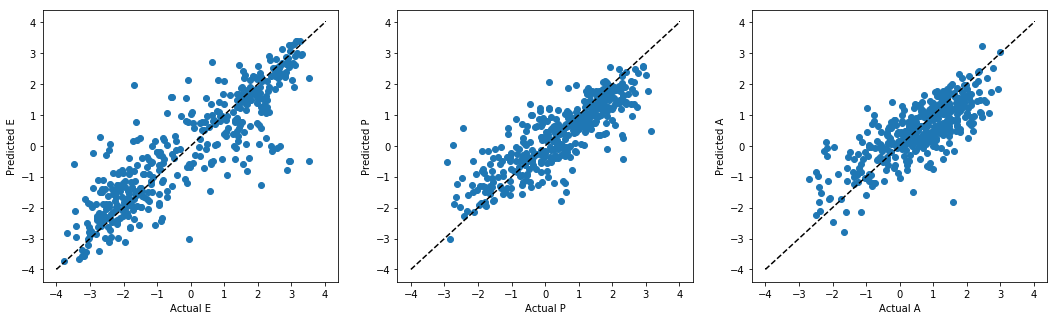

In [20]:
fig = plt.figure(figsize=(18, 5)) 

plt1 = plt.subplot(1, 3, 1)
plt1.scatter(np.array(test['E'].astype(float)), predicts_E)
plt1.plot([-4, 4], [-4, 4], 'k,--')
plt.xlabel('Actual E')
plt.ylabel('Predicted E')

plt2 = plt.subplot(1, 3, 2)
plt2.scatter(np.array(test['P'].astype(float)), predicts_P)
plt2.plot([-4, 4], [-4, 4], 'k,--')
plt.xlabel('Actual P')
plt.ylabel('Predicted P')

plt3 = plt.subplot(1, 3, 3)
plt3.scatter(np.array(test['A'].astype(float)), predicts_A)
plt3.plot([-4, 4], [-4, 4], 'k,--')
plt.xlabel('Actual A')
plt.ylabel('Predicted A')

plt.show()

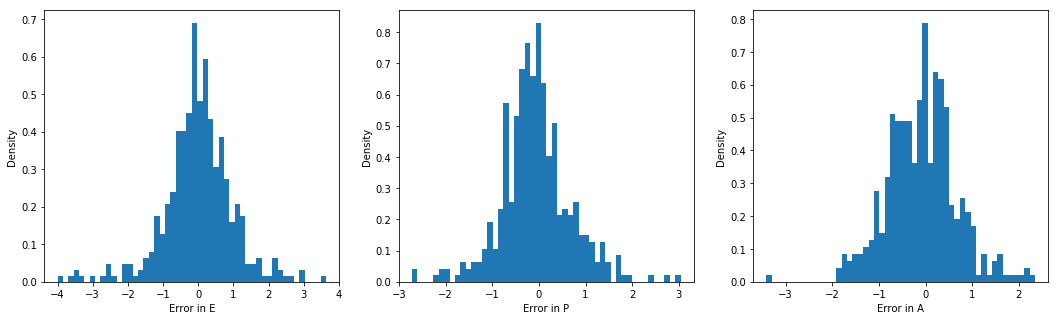

In [21]:
fig = plt.figure(figsize=(18, 5)) 

plt1 = plt.subplot(1, 3, 1)
plt.hist(np.subtract(predicts_E,test['E']),bins=50,density=True)
plt.xlabel('Error in E')
plt.ylabel('Density')

plt2 = plt.subplot(1, 3, 2)
plt.hist(np.subtract(predicts_P,test['P']),bins=50,density=True)
plt.xlabel('Error in P')
plt.ylabel('Density')

plt3 = plt.subplot(1, 3, 3)
plt.hist(np.subtract(predicts_A,test['A']),bins=50,density=True)
plt.xlabel('Error in A')
plt.ylabel('Density')

plt.show()

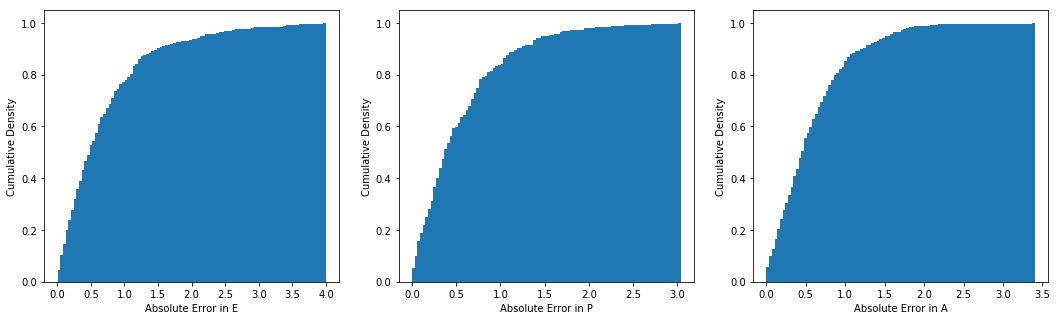

In [22]:
fig = plt.figure(figsize=(18, 5)) 

plt1 = plt.subplot(1, 3, 1)
plt.hist(np.absolute(np.subtract(predicts_E,test['E'])),bins=100,density=True, cumulative=True)
plt.xlabel('Absolute Error in E')
plt.ylabel('Cumulative Density')

plt2 = plt.subplot(1, 3, 2)
plt.hist(np.absolute(np.subtract(predicts_P,test['P'])),bins=100,density=True, cumulative=True)
plt.xlabel('Absolute Error in P')
plt.ylabel('Cumulative Density')

plt3 = plt.subplot(1, 3, 3)
plt.hist(np.absolute(np.subtract(predicts_A,test['A'])),bins=100,density=True, cumulative=True)
plt.xlabel('Absolute Error in A')
plt.ylabel('Cumulative Density')

plt.show()

In [23]:
#Generating new concepts

#Below we create a dataset of idnetities, behaviors, and modifiers
new_words = []

with open('new_words_done.csv', 'r', encoding='utf-8-sig') as f:
    for line in f:
        term = line.strip()
        if term in glove1 and term in glove2 and term in glove3 and term in word2vec:
            datum = [term]
            datum += ['0','0','0']
            new_words.append(datum)

df_new = pd.DataFrame(data=new_words, columns=[columns[0]]+columns[4:])

df_new_2 = df.drop(['E','P','A'],axis=1)
df_new = df_new.append(df_new_2)

rand = np.random.rand(len(df_new)) < 0.5

df_new['behavior'] = df_new['behavior'].astype('float')
df_new['identity'] = df_new['identity'].astype('float')
df_new['modifier'] = df_new['modifier'].astype('float')

train = df_new[rand]
test = df_new[~rand]

In [24]:
from sklearn.svm import SVC as svc
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall

embeds_train = get_vecs(train['term'])
embeds_test = get_vecs(test['term'])

#We then train support vector classifiers

identity = svc()

identity.fit(embeds_train, train['identity'])

predicts_svc_id = identity.predict(embeds_test)

print('IDENTITY PRECISION: ',precision(test['identity'],predicts_svc_id))
print('IDENTITY RECALL: ',recall(test['identity'],predicts_svc_id),'\n')

behavior = svc()

behavior.fit(embeds_train, train['behavior'])

predicts_svc_bhv = behavior.predict(embeds_test)

print('BEHAVIOR PRECISION: ',precision(test['behavior'],predicts_svc_bhv))
print('BEHAVIOR RECALL: ',recall(test['behavior'],predicts_svc_bhv),'\n')

modifier = svc()

modifier.fit(embeds_train, train['modifier'])

predicts_svc_mod = modifier.predict(embeds_test)

print('MODIFIER PRECISION: ',precision(test['modifier'],predicts_svc_mod))
print('MODIFIER RECALL: ',recall(test['modifier'],predicts_svc_mod))

IDENTITY PRECISION:  0.9405204460966543
IDENTITY RECALL:  0.755223880597015 

BEHAVIOR PRECISION:  0.8731343283582089
BEHAVIOR RECALL:  0.7069486404833837 

MODIFIER PRECISION:  0.8801369863013698
MODIFIER RECALL:  0.8595317725752508


In [25]:
import random

def classify(word, c_behavior, c_modifier, c_identity):
    
    #A helper dunction which uses three classifiers
    #and predicts whether a word is a behavior, a modifier,
    #and an identity and then outputs a prediction
    
    
    x = list(glove1[word]) + list(glove2[word]) + list(glove3[word]) + list(word2vec[word])
    x = np.array(x).reshape(1, -1)
    
    behavior = c_behavior.predict(x)
    modifier = c_modifier.predict(x)
    identity = c_identity.predict(x)
    
    if sum([behavior,modifier,identity]) == 1:
        if behavior:
            return 'behavior'
        elif modifier:
            return 'modifier'
        elif identity:
            return 'identity'
    else:
        return None
    

identities = set()
modifiers = set()
behaviors = set()

n_behaviors = 400 #number of desired behaviors for prediction set
n_identities = 400 #number of desired identities for prediction set
n_modifiers = 400 #number of desired modifiers for prediction set

i = 500 #starting index (i.e. " I don't want i+1 most common words to be in prediction set")
vocab = list(glove1.keys())

while any([len(identities)<n_identities, 
           len(behaviors)<n_behaviors, 
           len(modifiers)<n_modifiers]):
    w = vocab[i]
    i += 1
    if w in glove2 and w in glove3 and w in word2vec and "*" not in w:
        if not df['term'].str.contains(w.lower()).any():
            y = classify(w.lower(), behavior, modifier, identity)
            if y == 'behavior':
                behaviors.add(w)
            elif y == 'modifier':
                modifiers.add(w)
            elif y == 'identity':
                identities.add(w)


In [26]:
def pred(w, models=[embeds_E, embeds_P, embeds_A], norm=True):
    if norm:
        X = normalize(get_vec(w).reshape(1,-1))
    pred_E = models[0].predict(X)
    X = np.append(X,pred_E.reshape((len(pred_E),1)),1)
    pred_P = models[1].predict(X)
    X = np.append(X,pred_P.reshape((len(pred_P),1)),1)
    pred_A = models[2].predict(X)
    return (float(pred_E), float(pred_P), float(pred_A))

In [27]:
with open('behavior_preds.csv', 'w', newline='') as csvfile:
    f = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    f.writerow(['TERM','E','P','A'])
    for i in behaviors:
        f.writerow([i] + list(pred(i)))
        
with open('identity_preds.csv', 'w', newline='') as csvfile:
    f = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    f.writerow(['TERM','E','P','A'])
    for i in identities:
        f.writerow([i] + list(pred(i)))
        
with open('modifier_preds.csv', 'w', newline='') as csvfile:
    f = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    f.writerow(['TERM','E','P','A'])
    for i in modifiers:
        f.writerow([i] + list(pred(i)))

In [28]:
data = [[x[0]] + x[4:] for x in data]
pos_identities = set()
pos_behaviors = set()
pos_modifiers = set()

In [29]:
for fname in [('Positive_modifiers.csv',[0, 0, 1]),('Positive_identities.csv',[0, 1, 0]),
              ('Positive_behaviors.csv',[1, 0, 0]),('new_words_done.csv',[0,0,0])]:
    with open(fname[0], 'r', encoding='utf-8-sig') as f:
        for line in f:
            if line.strip() in word2vec and line.strip() in glove1 and line.strip() in glove2 and line.strip() in glove3:
                data.append([line.strip()] + fname[1])
                if fname[0] == 'Positive_modifiers.csv':
                    pos_modifiers.add(line.strip())
                elif fname[0] == 'Positive_identities.csv':
                    pos_identities.add(line.strip())
                elif fname[0] == 'Positive_behaviors.csv':
                    pos_behaviors.add(line.strip())

df_new = pd.DataFrame(data = data, columns=['term','behavior','identity','modifier'])

In [30]:
rand = np.random.rand(len(df_new)) < 0.8
train = df_new[rand]
test = df_new[~rand]

embeds_train = get_vecs(train['term'])
embeds_test = get_vecs(test['term'])

identity = svc()

identity.fit(embeds_train, train['identity'])

predicts_svc_id = identity.predict(embeds_test)

print('IDENTITY PRECISION: ',precision(test['identity'],predicts_svc_id))
print('IDENTITY RECALL: ',recall(test['identity'],predicts_svc_id),'\n')

behavior = svc()

behavior.fit(embeds_train, train['behavior'])

predicts_svc_bhv = behavior.predict(embeds_test)

print('BEHAVIOR PRECISION: ',precision(test['behavior'],predicts_svc_bhv))
print('BEHAVIOR RECALL: ',recall(test['behavior'],predicts_svc_bhv),'\n')

modifier = svc()

modifier.fit(embeds_train, train['modifier'])

predicts_svc_mod = modifier.predict(embeds_test)

print('MODIFIER PRECISION: ',precision(test['modifier'],predicts_svc_mod))
print('MODIFIER RECALL: ',recall(test['modifier'],predicts_svc_mod))

IDENTITY PRECISION:  0.8978102189781022
IDENTITY RECALL:  0.8482758620689655 

BEHAVIOR PRECISION:  0.8984375
BEHAVIOR RECALL:  0.7142857142857143 

MODIFIER PRECISION:  0.9368421052631579
MODIFIER RECALL:  0.9175257731958762


In [31]:
df_new

,term,behavior,identity,modifier
0,baby,0,1,0
1,bachelor,0,1,0
2,backstabber,0,1,0
3,bailiff,0,1,0
4,baker,0,1,0
5,bandit,0,1,0
6,banker,0,1,0
7,baptist,0,1,0
8,barber,0,1,0
9,bartender,0,1,0


In [32]:
import random

def classify(word, c_behavior, c_modifier, c_identity):
    x = list(glove1[word]) + list(glove2[word]) + list(glove3[word]) + list(word2vec[word])
    x = np.array(x).reshape(1, -1)
    
    behavior = c_behavior.predict(x)
    modifier = c_modifier.predict(x)
    identity = c_identity.predict(x)
    
    if sum([behavior,modifier,identity]) == 1:
        if behavior:
            return 'behavior'
        elif modifier:
            return 'modifier'
        elif identity:
            return 'identity'
    else:
        return None
    

identity_preds = set()
modifier_preds = set()
behavior_preds = set()

n_behaviors = 300 #number of desired behaviors for prediction set
n_identities = 300 #number of desired identities for prediction set
n_modifiers = 300 #number of desired modifiers for prediction set

i = 200 #starting index (i.e. " I don't want i+1 most common words to be in prediction set")
vocab = list(glove1.keys())

while any([len(identity_preds)<n_identities, len(behavior_preds)<n_behaviors, len(modifier_preds)<n_modifiers]):
    w = vocab[i]
    i += 1
    if w in glove2 and w in glove3 and w in word2vec and "*" not in w:
        if not df['term'].str.contains(w.lower()).any():
            y = classify(w.lower(), behavior, modifier, identity)
            if y == 'behavior':
                behavior_preds.add(w)
                print(w)
            elif y == 'modifier':
                modifier_preds.add(w)
                print(w)
            elif y == 'identity':
                identity_preds.add(w)
                print(w)


'll
say
must
looking
against
feel
'd
says
provide
enough
try
yet
buy
someone
others
anything
offer
become
check
trying
anyone
quite
create
wanted
share
perfect
learn
especially
stay
bring
sound
cannot
yourself
return
cause
drive
cover
continue
interesting
send
seem
player
amazing
wish
chance
themselves
receive
tried
build
cheap
opportunity
excellent
looked
wonderful
completely
difficult
felt
himself
wants
ability
fall
sell
safe
break
feeling
awesome
considered
spend
highly
dont
improve
expect
sounds
normal
knows
helps
funny
allowed
apply
truly
positive
recommend
useful
dark
named
develop
wear
particularly
owner
extremely
appropriate
totally
director
produce
select
helped
carry
reduce
absolutely
remove
complex
driver
handle
seemed
soft
prevent
solid
fuck
remain
mention
expensive
mom
decide
slow
aware
lovely
attempt
fill
perform
discuss
fantastic
realize
slightly
becoming
maintain
willing
gonna
dedicated
senior
install
explain
exciting
negative
agent
detailed
imagine
worry
pull
limit
reg

lucrative
spokesperson
administer
unite
tranny
astonishing
flawless
inflammatory
columnist
chew
unpredictable
quirky
reinforce
digest
softer
admired
fools
erase
fluffy
induce
obliged
discrete
shitty
youthful
respectable
gracious
redirect
irregular
filmmaker
intrigued
catchy
observer
abide
eclectic
enroll
starred
imposing
fraudulent
depart
swollen
pricey
newbie
striker
spokeswoman
testify
lethal
improper
cookbook
inherently
knight
dwell
puppet
refrain
inquire
conquer
handler
trivial
webmaster
pleasantly
differentiate
ditch
inspires
empower
suspend
protector
clamp
heroic
wrath
scout
cleanse
alleviate
translator
unsafe
ridiculously
fetch
slash
contend
immensely
horrific
fuss
shareholder
wary
rogue
incumbent
poetic
ineffective
linebacker
declares
paced
unusually
sober
coherent
terrifying
repay
tedious
commence
comforting
wig
reckon
moderator
bleed
insurer
disastrous
frightened
validate
refugee
articulate
catcher
inactive
correspondent
tremendously
filthy
haters
unwilling
slaughter
chubby
s